In [1]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import scipy
from sklearn.decomposition import PCA
from scipy.spatial import distance_matrix

from tqdm import tqdm

from visuals import *
from my_lib import *

In [146]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [133]:
plt.rcParams['text.usetex'] = False

In [124]:
def HankelMatrix(qwe, L):  
    N = qwe.shape[0]
    return scipy.linalg.hankel(qwe[ : N - L + 1], qwe[N - L : N])

def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [125]:
x_acc, t = prepare_time_series('./data/long_walk_100_acc.csv',centred = False)

n_steps = 20
T = 462

dt = T * n_steps

x_acc = x_acc[7174:7174+dt]
fig = go.Figure()
fig.add_scatter(y = x_acc[:], mode='lines', name='x_acc')
fig.show()

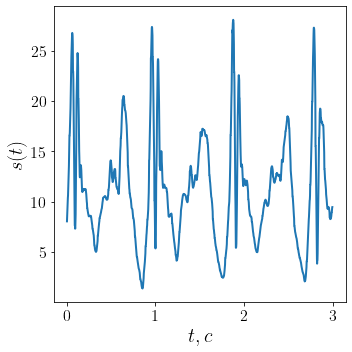

In [129]:
plt.plot(np.arange(0,1500)/500, x_acc[:1500])
plt.xlabel('$t,c$', size=20)
plt.ylabel('$s(t)$',size=20)
plt.tight_layout()
plt.savefig('ts_slide.png',
            dpi=300)
plt.show()

In [5]:
from my_lib import NWregression

In [131]:
X_h = HankelMatrix(x_acc, 500)

pca = PCA(n_components = 4)
X_PCA = pca.fit_transform(X_h)

phis = np.linspace(0, 2*np.pi * (n_steps - 1), len(X_PCA))%(2*np.pi)
phis = phis.reshape((len(phis),1))
M = 900
phi_mean = np.linspace(0,2*np.pi,M).reshape((M,1))

metric = lambda x,y: (1 - np.cos((x-y)))/2

model = NWregression(h =(2+.1)*np.pi/M, kernel = 'rectangular', metric = metric)

model.fit(phis,X_PCA)
regression = model.predict(phi_mean)
D = np.max(np.min(distance_matrix(X_PCA, regression, p = 2),axis = 1))

In [7]:
import statsmodels.api as sm
import scipy.stats
from scipy import stats

T = 462
X_temp = np.linspace(0,2*np.pi,T).reshape((T,1))
regression_for_loss = model.predict(X_temp)

dX = np.zeros_like(X_PCA[:(18*462)])
for i in range(1,18):
    dX[T*(i):T*(i+1)] = X_PCA[T*(i):T*(i+1)] - regression_for_loss

res = dX[:,0]

table_hypothesis = pd.DataFrame([['Нормальность', 'Шапиро-Уилка', 'отвергается', stats.shapiro(res)[1]],
                     ['Несмещённость', 'Уилкоксона', 'не отвергается', stats.wilcoxon(res)[1]],
                     ['Стационарность', 'KPSS', 'не отвергается', sm.tsa.stattools.kpss(res)[1]]])
table_hypothesis.columns = ['Гипотеза', 'Критерий', 'Результат проверки','Достигаемый уровень значимости']
table_hypothesis

/Users/tihonovdenis/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




,Гипотеза,Критерий,Результат проверки,Достигаемый уровень значимости
0,Нормальность,Шапиро-Уилка,отвергается,4.713577e-39
1,Несмещённость,Уилкоксона,не отвергается,2.697721e-01
2,Стационарность,KPSS,не отвергается,1.000000e-01


In [8]:
fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=700, height=700)
fig_2.add_trace(go.Scatter3d(x=X_PCA[:,0],
                             y=X_PCA[:,1],
                             z=X_PCA[:,2],
                             marker=dict(size=0.1,line=dict(width=0.01)),
                             name = 'X_PCA'
                            )
                )
fig_2.add_trace(go.Scatter3d(x=regression[:,0],
                             y=regression[:,1],
                             z=regression[:,2],
                             marker=dict(size=0.1,line=dict(width=0.01)),
                             name = 'Mean'
                            )
                )
fig_2.layout.template = 'plotly_white'
fig_2.show()

In [9]:
D = np.max(np.min(distance_matrix(X_PCA, regression, p = 2),axis = 1))

In [10]:
dist = lambda x,y: np.sum((x-y)**2)**.5

#Checking phase area
for i in tqdm(range(len(X_PCA))):
    s = [j for j in range(len(regression)) if dist(X_PCA[i],regression[j]) <= D]
    assert len(s) != 0,f'Problem in {i} point'

100%|██████████| 8741/8741 [00:57<00:00, 152.71it/s]


In [211]:
phase_history = []
x_phase_history = {}
step_eps = 4*np.pi/M
temp = 0

def L1(x):
    for i in range(len(x)):
        if x[i] < np.pi/2:
            x[i] = max(0,x[i])
        else:
            x[i] = 0
    return x

def L2(NN, phi):
    ans = 0
    for i in range(len(NN)):
        ans += (1 - np.cos(NN[i] - phi))/2
    return ans

def L3(NN, phi):
    pass

L4 = None

for i in tqdm(range(len(X_PCA[:4000]))):
    
    if len(phase_history) == 0:
        dists = [dist(X_PCA[i],regression[j]) for j in range(len(regression))]
        min_index = dists.index(min(dists))

        current_phi = np.linspace(0,2*np.pi,M)[min_index]
        
        x_phase_history[current_phi] = X_PCA[i]
        phase_history.append(current_phi)
        continue
        
    #ближайшие соседи на средней траектории
    NN_indexes = [j for j in range(len(regression)) if dist(X_PCA[i],regression[j]) <= D]
    NN_phases = [(2*np.pi*(ind/M)) for ind in NN_indexes]
    loss1 = lambda phases: np.sum(L1(phase_history[-1] - phases))
    
    #соседство с такими же фазами из предыстории
    NN_x_phases = [phase_history%(2*np.pi) for phase_history, x_history in x_phase_history.items() \
                   if dist(X_PCA[i],x_history) <= D/3]
    loss2 = lambda phases: L2(np.array(NN_x_phases), phases)
    
    #соседство по выбраным фазам в фазовом пространстве
    
    #loss3 = lambda phases: L3(np.array(NN_x_phases), phases)
    
    
    
    #оптимизация
    idx_min = np.argmin(
        loss1(np.array(NN_phases))\
        + loss2(np.array(NN_phases))\
        #+ loss3(np.array(NN_phases))
    )
    
    current_phi = NN_phases[idx_min]
        
    #заполнение истории
    x_phase_history[current_phi] = X_PCA[i]
    phase_history.append(current_phi)
phase_history = np.array(phase_history)

100%|██████████| 4000/4000 [00:43<00:00, 92.71it/s]


In [212]:
fig = go.Figure()
fig.add_scatter(y = phase_history,
                mode='lines',
                name='phase_history')
fig.show()

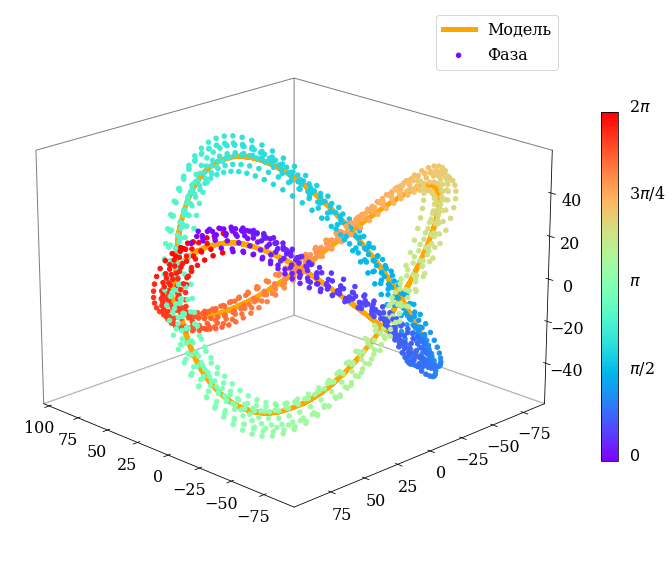

In [213]:
Y_ = X_PCA[:,:3]/1.1
regression_ = regression[:,:3]

ax = 0/180 * np.pi
ay = 30/180 * np.pi
az = 30/180 * np.pi

T_X = np.array([[1,0,0],
                [0,np.cos(ax),-np.sin(ax)],
                [0,np.sin(ax), np.cos(ax)]])

T_Y = np.array([[np.cos(ay),-np.sin(ay),0],
                [np.sin(ay), np.cos(ay),0],
                [0,0,1]])

T_Z = np.array([[ np.cos(az),0,np.sin(az)],
                [ 0,1,0],
                [-np.sin(az),0,np.cos(az)]])

Y_ = Y_@T_Y@T_X
regression_ = regression_@T_Y@T_X

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# ax.plot(Y_[:,0],
#         Y_[:,1],
#         Y_[:,2],
#         label='Фазовая траектория')

img =ax.scatter(Y_[:4000:3,0],
                Y_[:4000:3,1],
                Y_[:4000:3,2],
                c=cm.rainbow(phase_history[:4000:3]/(2*np.pi)),
                label='Фаза',
                alpha = 1)

m = cm.ScalarMappable(cmap=cm.rainbow)
m.set_array(phase_history)

cbar = fig.colorbar(m,shrink=0.5)

cbar.ax.get_yaxis().set_ticks([])
for i, lab in enumerate(['$0$','$\pi$/2','$\pi$','3$\pi$/4','2$\pi$']):
    cbar.ax.text(10, (3 * np.pi * i / 6), lab, size=16)

ax.plot(regression_[:,0],
        regression_[:,1],
        regression_[:,2],
        color = 'orange',
        label='Модель',
        lw = 5)

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.legend()
# fig.savefig('phase.eps',
#             format='eps',
#             dpi=600)
fig.tight_layout()
fig.savefig('phas_final.png',
            dpi=600,
           bbox_inches='tight')

# fig.savefig('phase.pdf',
#             dpi=600)
fig.show()